# Analysis of Public Comments Regarding the EPA's Revised Definition of "Waters of the United States" (WOTUS)

In early 2017, President Trump signed an Executive Order<sup>[1](#footnote1)</sup> requesting that agencies review a 2015 rule regarding the "Waters of the United States". The agencies, including the Environmental Protection Agency (EPA) and the Department of the Army, were instructed to rescind or replace the rule, in accordance with law.

The agencies have since conducted a reevaluation and revision of the definition of "Waters of the United States". Their proposed rule redefines the scope of waters federally regulated under the Clean Water Act (CWA). This rule was open for public comment until April 15, 2019.

This project aims to apply Natural Language Processing (NLP) techniques to analyze the content of comments that are publicly available on the [regulations.gov web page](https://www.regulations.gov/docket?D=EPA-HQ-OW-2018-0149) for this docket. For technical reasons (see the [Data_Prep notebook](./Data_Prep.ipynb)), the dataset only includes ~8K comments, which are the ones typed directly onto the site. The dataset excludes another ~3K comments submitted in an attachment form (most of which were PDFs).

Notes:

<a name="footnote1">1</a>: Executive Order 13778, signed on February 28, 2017, titled "Restoring the Rule of Law, Federalism, and Economic Growth by Reviewing the 'Waters of the United States' Rule"

## Library Imports

In [1]:
# Standard imports
import re
import warnings
warnings.filterwarnings('ignore', 'DeprecationWarning') 

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Model and analysis imports
from scipy import linalg

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA, TruncatedSVD, NMF, PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from sklearn.manifold import TSNE

import spacy

from wordcloud import WordCloud

In [20]:
# Un-comment and run cell to install spaCy and language model
# import sys
# !conda install --yes --prefix {sys.prefix} spacy
# !{sys.executable} -m spacy download en_core_web_sm
# !{sys.executable} -m spacy download en_core_web_lg

In [3]:
full_df = pd.read_pickle('./Data/full_df.pkl')

full_df.head()

,Document Title,Document ID,Posted Date,Received Date,Document SubType,Post Mark Date,Document Detail,Comment
0,Anonymous public comment,EPA-HQ-OW-2018-0149-6689,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
1,Anonymous public comment,EPA-HQ-OW-2018-0149-6688,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,I write to express my opposition to the Enviro...
2,Anonymous public comment,EPA-HQ-OW-2018-0149-7377,2019-05-01,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please abandon this proposed rollback of the 2...
3,Anonymous public comment,EPA-HQ-OW-2018-0149-6707,2019-04-29,2019-04-11,Public Comment,04/11/2019,https://www.regulations.gov/document?D=EPA-HQ-...,"My husband and I have two wonderful daughters,..."
4,Comment submitted by T. Dahlin,EPA-HQ-OW-2018-0149-7983,2019-05-01,2019-04-12,Public Comment,04/12/2019,https://www.regulations.gov/document?D=EPA-HQ-...,Please do not change the definitions within th...


In [106]:
# Process comment column for topic analysis

# Remove punctuation
# full_df['Comment_processed'] = full_df['Comment'].map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the comments to lowercase
# full_df['Comment_processed'] = full_df['Comment'].map(lambda x: x.lower())

# full_df.head()

In [4]:
comments = full_df['Comment']

comments.head()

0    I write to express my opposition to the Enviro...
1    I write to express my opposition to the Enviro...
2    Please abandon this proposed rollback of the 2...
3    My husband and I have two wonderful daughters,...
4    Please do not change the definitions within th...
Name: Comment, dtype: object

In [5]:
# Split comments into training and test sets
X_train, X_test = train_test_split(comments,
                                   test_size=0.2,
                                   random_state=42)

print(X_train.shape, X_test.shape)

(6549,) (1638,)


In [6]:
# Helper function to show top words per topics
def show_topics(Vh, vocab_array, n_top_words=8):
    """
    Returns a list of the n_top_words from topic matrix Vh
    :param Vh: a topic (rows) by vocabulary (cols) orthonormal matrix
    :param vocab_array: a Numpy array of the vocabulary terms
        from the documents used in the analysis
    :param n_top_words: int of how many words to show by topic
    :return: list of strings with top words by topic in Vh
    
    >>>show_topics(my_Vh_matrix[:4], vocab)
    ['space launch satellite nasa commercial market satellites data',
     'god atheists atheism religious believe argument religion true',
     'nasa space lunar available mars probe moon edu',
     'atheists religious atheism god religion believe belief atheist']
    """
    top_words = lambda t: [vocab_array[i] for i in np.argsort(t)[:-n_top_words-1:-1]]
    topic_words = ([top_words(t) for t in Vh])
    return [' '.join(t) for t in topic_words]

In [16]:
# Helper function to plot most common words
def plot_most_common_words(count_data, count_vect, n=10):
    """
    :param count_data: data after running a CountVectorizer.fit_transform()
    :param count_vect: a CountVectorizer() instance
    :param n: int for how many top words to plot
    :return: None; plots a matplotlib.pyplot bar chart of top n words
    """
    import matplotlib.pyplot as plt
    
    words = count_vect.get_feature_names()
    print(len(words))
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 

    plt.bar(x_pos, counts,align='center')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('Words')
    plt.ylabel('Counts')
    plt.title('{} Most Common Words'.format(n))
    plt.show()

## Create Term-Document Matrix

In [8]:
# Load language model
nlp = spacy.load('en_core_web_lg')

In [10]:
# Create custom tokenizer/lemmatizer
lemmatizer = spacy.lang.en.English()

def spacy_tokenizer(doc):
    """
    Applies spaCy's built-in tokenizer pipeline capabilities to
        to keep a lemmatized version of each token for alpha-
        numeric word's only (excludes punctuation and whitespace)
    """
    tokens = lemmatizer(doc)
    return([token.lemma_ for token in tokens if token.lemma_.isalnum()])

In [11]:
# Stop words
stop_words = list(nlp.Defaults.stop_words)
tokenized_stop_words = spacy_tokenizer(' '.join(stop_words))

In [27]:
# Create term-document matrix using a count vectorizer
count_vec = CountVectorizer(stop_words=tokenized_stop_words,
                            tokenizer=spacy_tokenizer,
                            max_df=0.95,
                            min_df=5)

count_data = count_vec.fit_transform(X_train)
print(count_data.shape)

vocab = np.array(count_vec.get_feature_names())

(6549, 4141)


In [29]:
s = 200
print(vocab[s:s+100])

['adhere' 'adjacency' 'adjacent' 'adjoin' 'admin' 'administer'
 'administration' 'administrative' 'administrator' 'admit' 'adopt'
 'adoption' 'adult' 'advance' 'advantage' 'adverse' 'adversely' 'advice'
 'advise' 'advisory' 'advocacy' 'advocate' 'affair' 'affect' 'affiliation'
 'afford' 'affordable' 'affront' 'afraid' 'afternoon' 'ag' 'age' 'agency'
 'agencyepa' 'agencys' 'agenda' 'agendum' 'agent' 'aggregate' 'aggressive'
 'aggressively' 'ago' 'agree' 'agreement' 'agribusiness' 'agricultural'
 'agriculture' 'ahead' 'aid' 'aim' 'air' 'aka' 'al' 'alabama' 'alarm'
 'alaska' 'alexander' 'alga' 'algal' 'align' 'alike' 'alive' 'alleviate'
 'alliance' 'allow' 'ally' 'almighty' 'alongside' 'alot' 'alter'
 'alteration' 'alternative' 'amanda' 'amaze' 'ambiguity' 'ambiguous'
 'amend' 'amendment' 'amenity' 'america' 'american' 'americans' 'americas'
 'amp' 'amphibian' 'ample' 'amy' 'analysis' 'analyze' 'ancestor' 'ancient'
 'anderson' 'andrew' 'andy' 'angle' 'angler' 'angry' 'animal' 'ann' 'anna'

In [32]:
# Create term-document matrix using TF-IDF vectorizer
tf_vec = TfidfVectorizer(stop_words=tokenized_stop_words,
                         tokenizer=spacy_tokenizer,
                         max_df=0.95,
                         min_df=5)

tf_data = tf_vec.fit_transform(X_train)
print(tf_data.shape)

vocab_tf = np.array(tf_vec.get_feature_names())

(6549, 4141)


4141


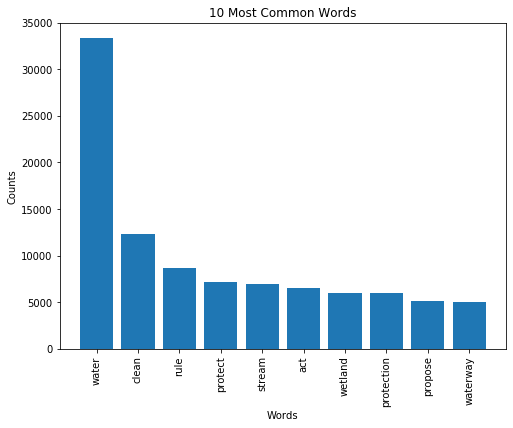

In [33]:
plt.figure(figsize=(8, 6));
plot_most_common_words(count_data, count_vec)

## Topic Analysis

### Word Cloud

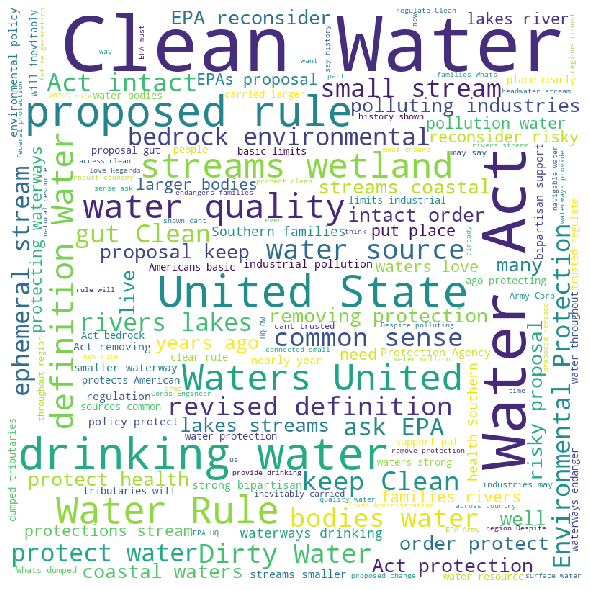

In [35]:
# Combine comments into one "text"
text = ' '.join(comments)

wordcloud = WordCloud(width = 800,
                      height = 800, 
                      background_color ='white',
                      min_font_size = 10).generate(text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor=None);
plt.imshow(wordcloud);
plt.axis("off");
plt.tight_layout(pad=0);
# plt.savefig('./Figures/wordcloud.png');
plt.show();

### Singular Value Decomposition (SVD) Analysis

In [36]:
# Run SVD to create topic matrices
U, s, Vh = linalg.svd(count_data.todense(), full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(6549, 4141) (4141,) (4141, 4141)


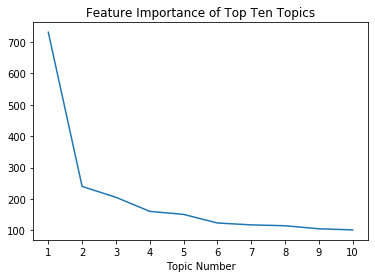

In [37]:
# Plot s to see where topic importance drops off
plt.plot(range(1, 11), s[:10]);
plt.xticks(range(1, 11));
plt.xlabel('Topic Number');
plt.title('Feature Importance of Top Ten Topics');

In [38]:
# Print top 10 topics
show_topics(Vh[:10], vocab)

['0149please overstep communist humble tyranny entrust jack edward',
 'clean waterway act family proposal drink industry water',
 'stream wetland downstream flow headwater small river protection',
 'water park protection quality state wetland change unite',
 'state definition unite waterway tributary change provide protection',
 'farmer farm water protect land quality downstream park',
 'waterway new quality farmer leave rule category adjacent',
 'state definition unite dirty community important people polluter',
 'act clean state support unite propose rule category',
 'water propose flow definition wotus regulation drink support']

Aside from the gibberish that comprises the first topic, the others all seem to reasonably fit the core themes in the public comments.

### LDA

LDA analysis had much higher perplexity scores (12K vs 995 at 12 topics) using the TF-IDF count data vs. the standard count vectorizer.

In [39]:
n_topics = 8

# Create and fit an LDA model
lda = LDA(n_components=n_topics,
          n_jobs=-1,
          random_state=42)

lda.fit(count_data)  # tfidf_data had much higher perplexity scores

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=8, n_jobs=-1,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [40]:
lda.components_.shape

(8, 4141)

In [41]:
print('Final perplexity score: {0:,.0f}'.format(lda.bound_))

Final perplexity score: 474


In [42]:
show_topics(lda.components_, vocab, 10)

['water clean rule epa community protection act drink waterway dirty',
 'water wetland protection clean stream change quality protect propose park',
 'water clean act protect waterway stream proposal family river drink',
 'water rule clean act state propose unite protection waterway wetland',
 'water rule state definition propose unite wotus clean epa new',
 'water rule farmer epa farm clean support clear protect land',
 'water stream wetland clean rule downstream protect flow river propose',
 'water people regulation life live right need protect clean want']

In [43]:
# Compare perplexity scores for various number of topics
p = []

for n in range(2, 19, 2):
    mod = LDA(n_components=n,
              n_jobs=-1,
              random_state=42)
    mod.fit(count_data)
    p.append(mod.bound_)
    print('Number of Topics: {}'.format(n))
    print('Perplexity score: {0:,.0f}'.format(mod.bound_))
    print('----------------')

Number of Topics: 2
Perplexity score: 572
----------------
Number of Topics: 4
Perplexity score: 516
----------------
Number of Topics: 6
Perplexity score: 491
----------------
Number of Topics: 8
Perplexity score: 474
----------------
Number of Topics: 10
Perplexity score: 467
----------------
Number of Topics: 12
Perplexity score: 467
----------------
Number of Topics: 14
Perplexity score: 468
----------------
Number of Topics: 16
Perplexity score: 452
----------------
Number of Topics: 18
Perplexity score: 436
----------------


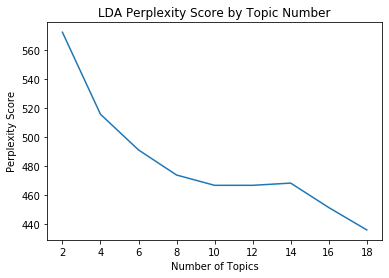

In [44]:
# Plot the perplexity scores
plt.plot(range(2, 19, 2), p);
plt.title('LDA Perplexity Score by Topic Number');
plt.ylabel('Perplexity Score');
plt.xlabel('Number of Topics');

The sharpest decline in perplexity score happens from two to eight topics, with a flattening out thereafter.

### NMF

In [45]:
# Create and fit an NMF model with count vectorizer
nmf = NMF(n_components=n_topics,
          random_state=42)

W1 = nmf.fit_transform(count_data)
H1 = nmf.components_

In [46]:
show_topics(H1, vocab, 10)

['water clean act protect need live life drink quality pollution',
 'rule propose epa farmer support farm land water corp clear',
 'stream wetland downstream rule flow propose small protect river headwater',
 'waterway protect stream proposal family act water industry drink river',
 'water clean rule community dirty epa polluter safeguard family waterway',
 'water state definition unite wetland protection change propose wotus revise',
 'waterway rule propose stream wetland new leave category ephemeral protection',
 'park protection water wetland quality stream propose small waterway country']

In [47]:
# Create and fit an NMF model with TF-IDF vectorizer
nmf_tf = NMF(n_components=n_topics,
             random_state=42)

W1_tf = nmf_tf.fit_transform(tf_data)
H1_tf = nmf_tf.components_

In [48]:
show_topics(H1_tf, vocab)

['wetland stream downstream water flow propose headwater rule',
 'water protect act waterway clean family proposal region',
 'water clean community safeguard dirty instead polluter rule',
 'rule farmer water clear support land new farm',
 'overall protection loss concern harm rappahannock water impact',
 'water unite state dangerous dirty definition revise people',
 'park water clean protection wetland quality country roll',
 'blanket arroyos handout cinegas acequias creek disregard connectivity']

## Clustering Analysis

In [49]:
# Create various options for the word vectorizer
# n_feats = 14000
use_bigrams = True

if use_bigrams:
    b = 2
else:
    b = 1

# Comment out all vectorizer defs except the one to use
# Simple count vectorizer
vectorizer = CountVectorizer(stop_words=tokenized_stop_words,
                             tokenizer=spacy_tokenizer,
#                              max_features=n_feats,
                             ngram_range=(1, b))
chart_title = 'Count'

# Hashing vectorizer using L2 norm
# vectorizer = HashingVectorizer(stop_words=tokenized_stop_words,
#                                tokenizer=spacy_tokenizer,
#                                n_features=n_feats,
#                                ngram_range=(1, b),
#                                norm='l2')

# chart_title = 'HashL2'

# Hashing vectorizer normalized using TF-IDF
# hashy = HashingVectorizer(n_features=n_feats,
#                            stop_words='english',
#                            ngram_range=(1, b),
#                            norm=None)
# 
# chart_title = 'HashTFIDF'

# vectorizer = make_pipeline(hashy, TfidfTransformer())

# TF-IDF vectorizer
# vectorizer = TfidfVectorizer(max_features=n_feats,
#                              ngram_range=(1, b),
#                              stop_words='english')
# 
# chart_title = 'TFIDF'

In [50]:
# Transformed features
X_data = vectorizer.fit_transform(X_train)
print(X_data.shape)

(6549, 169469)


In [51]:
# Create and fit a KMeans algorithm
kmeans = KMeans(n_clusters=2,
                max_iter=100,
                n_init=1,
                n_jobs=-1)

kmeans.fit(X_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=2, n_init=1, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [52]:
# Examine metrics for KMeans
# print(kmeans.labels_)
print('Inertia: {0: .3f}'.format(kmeans.inertia_))
print('Silhouette Coefficient: {0:.3f}'.format(
      metrics.silhouette_score(X_data, kmeans.labels_, sample_size=1000)))

Inertia:  1249972.812
Silhouette Coefficient: 0.262


In [53]:
# Compare metrics of different number of clusters
n_clusters = list(range(2, 13))
inertias = []
silhouettes = []

for n in n_clusters:
    model = KMeans(n_clusters=n,
                   max_iter=100,
                   n_init=1,
                   n_jobs=-1)
    model.fit(X_data)
    inertias.append(model.inertia_)
    silhouettes.append(metrics.silhouette_score(X_data, model.labels_, sample_size=1000))

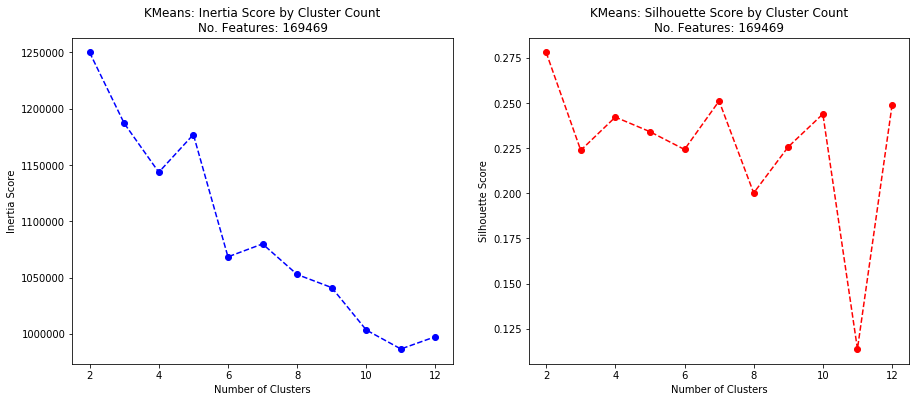

In [54]:
# Plot scores by cluster
plt.subplots(1, 2, figsize=(15, 6))

# Cluster-inertia plot
plt.subplot(1, 2, 1);
plt.plot(n_clusters, inertias, 'bo--');
plt.xlabel('Number of Clusters');
plt.ylabel('Inertia Score');
plt.title('KMeans: Inertia Score by Cluster Count\nNo. Features: {}'.format(X_data.shape[1]));

# Cluster-silhouette score plot
plt.subplot(1, 2, 2);
plt.plot(n_clusters, silhouettes, 'ro--');
plt.xlabel('Number of Clusters');
plt.ylabel('Silhouette Score');
plt.title('KMeans: Silhouette Score by Cluster Count\nNo. Features: {}'.format(X_data.shape[1]));

plt.savefig('./Figures/KMeans_{}{}_Inertia-Silhouette.png'
            .format(chart_title, 'Bigrams' if use_bigrams else ''));

**Inertia** calculates the sum of the squared distances between data points and their nearest cluster. Low overall values of inertia are generally better, but it will naturally favor having more clusters.

**Silhouette score** uses two scores to find the mean distance between each observation and all others - both in the same cluster and then in the nearest cluster. Values range from -1 to 1, where a score of 1 indicates the point is close to others in the same cluster, but far away from the next cluster over. A score near -1 indicates the point is not near ones in its cluster but close to the next nearest cluster. And a score of 0 indicates overlapping clusters, where an observation is close to the decision boundary. A score closest to 1 is ideal, as that indicates tight, highly separable clusters.

The KMeans algorithm was run with four different pre-processing applications, then using unigrams only vs. also including bigrams. Including bigrams did not generally improve the metrics, therefore the charts weren't included below.

1) **Count Vectorizer**

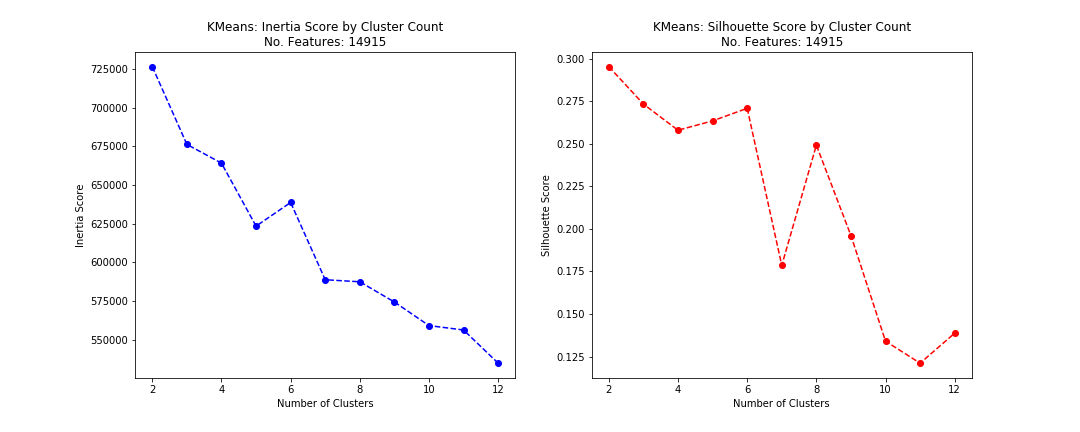

The count vectorizer plots had inertia values that were a factor of over a hundred times higher than all the others, but managed the highest overall silhouette scores, with the peak value over 0.3 at two clusters.

2) **Hashing Vectorizer with L2 Norm**

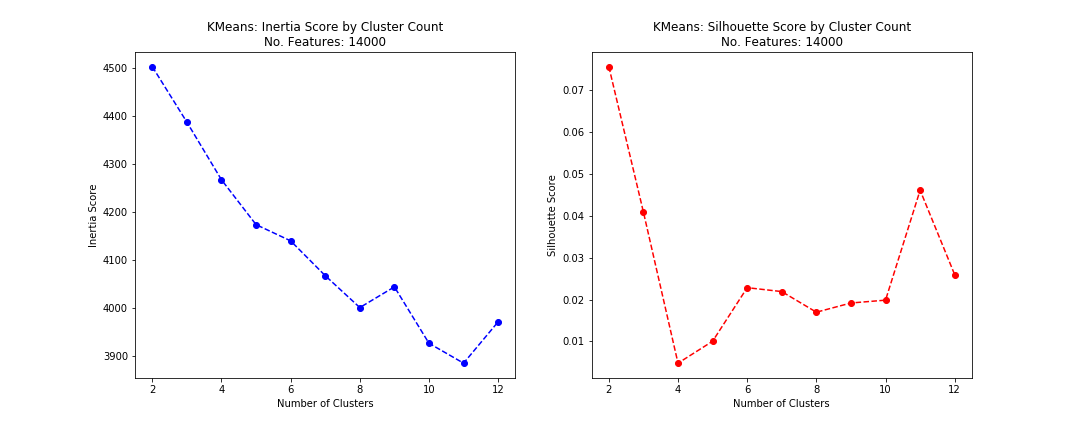

This method had the lowest overall inertia values and second highest overall silhouette scores.

While the inertia score is the highest for two clusters (as expected), the silhouette score favors two clusters as being the optimal number. This aligns with the nature of the dataset having sets of comments from two distinct groups: those that support the rule change and those that oppose it.

There are two trends worth pointing out in these chart. One is the jump from eight clusters to nine - there's little improvement to the inertia calculation, but almost a 4x improvement of silhouette score. This is repeated to a lesser degree in the move from ten to eleven clusters. The other is the move from four to five clusters - there's a steady decrease in inertia but an almost 2x increase in the silhouette score.

3) **Hashing Vectorizer Normalized using TF-IDF**

![Inertia and silhouette scores by cluster]()

This analysis shows a completely different story, indicating that ten clusters is optimal. That cluster count has both the minimum inertia value as well as the peak silhouette score. However, the overall inertia and silhouette values are worse than the previous analysis using an L2 norm. The inertia scores are all higher, and the best silhouette score is still below the two-cluster score from before.

4) **TF-IDF Vectorizer**

![Inertia and silhouette scores by cluster]()

Not surprisingly, this analysis is more similar to the hashing vectorizer with TF-IDF normalization than the hashing vectorizer with an L2 norm. The overall score values are in line with where they fell out in the other TF-IDF-based analysis. Nine seems to be a good choice of clusters, with its dip in inertia and jump in silhouette scores (especially off the trough at eight clusters). However, the silhouette scores continue to climb at the limit of twelve clusters, indicating there could be better performance.

In [284]:
# Print comments from cluster 0
cluster_0 = X_train[kmeans.labels_ == 0]

for row in cluster_0.head(20):
    print(row)
    print('\n----------\n')

I Strongly Oppose EPAs Revised Definition of Waters of the United States I am writing because I am opposed to EPAs revised definition of Waters of the United States (WOTUS), as well as the specific exclusions set forth in the proposed rule. This revised definition attempts to roll back the scope of the Clean Water Act and limit protections for wetlands and waterways that drain into the Salish Sea.  Our waterways and wetlands, and the marine ecosystems these waters drain into, such as our Salish Sea, are invaluable assets to our communitiesthey provide us with sources of safe and affordable drinking water, as well as recreational areas, jobs, and wildlife habitat. We should be strengthening protections for clean water; not rolling them back. The Clean Water Act was created in recognition of the fact that water flows downstream. Small creeks and wetlands flow into the sea, as well as into our major rivers and lakes. In order to protect the waters of the United States, as directed by Cong

In [285]:
# Print comments from cluster 1
cluster_1 = X_train[kmeans.labels_ == 1]

for row in cluster_1.head(20):
    print(row)
    print('\n----------\n')

We da people have da power to send u to Washington with our votes,should be ashamed to take our property rights,may this world find da Lord's mercy especially TV those that abuse da system...!! Regards, William Perez

----------

April 15, 2019U.S. Environmental Protection Agency EPA Docket Center Office of Water DocketMail Code 28221T 1200 Pennsylvania Avenue, NWWashington, DC 20460RE:Docket ID No. EPA-HQ-OW-2018-0149To Whom it May Concern:I am a farmer in Champaign county, Illinois. I am writing to submit comments to the United States Environmental Protection Agency (EPA) and the United States Army Corps of Engineers (Corps) in support of the proposal for the revised definition of Waters of the United States under the Clean Water Act.It is time for clear rules that protect both the nations water bodies and farmers ability to produce food, fiber and fuel. This proposed rule would have the ability to end years of uncertainty over where the jurisdiction of EPA and the Corps begins and e

In [286]:
# Reduce dimensions with PCA
pca = PCA(n_components=50)
components = pca.fit_transform(X_data.todense())
print(pca.explained_variance_ratio_)
sum(pca.explained_variance_ratio_)

[0.08124027 0.04082698 0.03122189 0.02642479 0.0227979  0.01985517
 0.01646931 0.01495584 0.01351357 0.01123761 0.01051369 0.01004826
 0.00963115 0.00899073 0.00834738 0.00795024 0.00750748 0.00687052
 0.00667233 0.00647183 0.00631327 0.00614078 0.0058873  0.00565932
 0.00543251 0.00528543 0.00506265 0.00493456 0.00463233 0.00449475
 0.00437101 0.0042737  0.00413495 0.00394285 0.00391367 0.00377025
 0.0037154  0.00364628 0.00356467 0.00347221 0.00336801 0.00329348
 0.00321198 0.00313524 0.00300147 0.00296154 0.00293906 0.00287299
 0.00284875 0.00279755]


0.4846248798398125

In [287]:
components.shape

(6549, 50)

In [288]:
# Re-create DF with labeled clusters
col_names = ['pca_{}'.format(i + 1) for i in range(pca.n_components_)]

pca_df = pd.DataFrame(components, columns=col_names, index=X_train.index)
pca_df['cluster'] = kmeans.labels_

pca_df.head()

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,...,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49,pca_50,cluster
3783,0.465974,-0.199927,-0.052149,0.016421,-0.069937,-0.013369,-0.007073,0.045631,0.023347,-0.042433,-0.023722,0.002225,0.002636,0.041858,0.000912,-0.007478,-0.086943,-0.012971,0.129483,0.044761,0.032072,0.067219,0.077831,-0.039294,-0.050399,...,0.001035,-0.012884,-0.037311,0.042776,-0.049355,0.013943,-0.005530,-0.003011,0.021945,-0.061847,0.005753,-0.043010,0.011575,0.009988,-0.002009,0.073999,0.009199,-0.051703,0.016283,0.001506,-0.004950,0.036005,-0.013204,-0.032759,1
2110,0.075220,0.342818,-0.126787,-0.188438,0.258356,0.107678,0.047685,0.024374,-0.144179,-0.086772,0.031796,-0.126517,0.012539,-0.083809,0.022696,0.109924,0.067819,0.131734,0.105375,-0.064473,-0.155133,0.015228,0.009979,-0.013545,0.060321,...,-0.022572,-0.129340,-0.010870,-0.047707,0.093658,-0.028943,-0.008495,-0.015211,0.004345,-0.018739,-0.082665,0.016461,0.146109,0.036577,0.063682,0.053431,0.013145,-0.012462,-0.033243,-0.002794,0.003139,0.067564,-0.008373,0.000986,1
2002,-0.276043,0.146000,0.204230,0.066987,-0.040726,0.042385,0.168549,-0.134641,0.062993,0.069689,0.047931,-0.057566,0.090857,0.014993,0.066270,-0.001338,-0.023863,-0.030019,-0.014259,-0.054749,-0.027906,-0.058185,0.025394,0.007828,-0.073840,...,0.012709,-0.043637,-0.000430,-0.033803,-0.074859,-0.028190,0.039299,0.024493,0.056459,-0.050194,0.082856,-0.003085,0.012380,0.013630,0.020525,0.031753,0.019995,0.042261,-0.038891,-0.044862,0.003236,-0.034517,-0.018466,0.023342,0
3047,-0.350531,-0.288782,0.064524,-0.084224,0.143155,0.125172,0.118601,0.042088,0.054353,-0.016373,-0.031769,-0.089723,0.018974,0.075473,-0.038363,-0.029907,0.026424,0.051731,-0.001673,-0.038999,0.005145,0.013254,0.033055,-0.089768,-0.027034,...,-0.047633,0.045363,0.007194,0.015361,-0.044371,0.076576,0.059043,-0.000134,0.063129,-0.043699,-0.020941,0.003872,0.007704,0.016789,0.059692,0.032384,0.023535,-0.027245,0.036609,-0.023731,0.038344,0.016507,0.017296,-0.017767,0
418,-0.049658,0.108316,-0.127310,0.002050,-0.084568,-0.022325,-0.026890,-0.008427,-0.029763,0.123685,-0.036831,0.059817,-0.009079,0.036660,-0.068333,-0.043086,0.094711,0.021803,0.033994,-0.066248,0.065402,-0.036531,-0.015851,-0.047729,0.040809,...,0.055929,-0.013888,0.034060,0.063415,-0.049201,-0.115886,-0.080795,-0.016620,0.065910,0.061345,-0.022592,-0.011654,-0.013927,-0.002050,-0.028655,0.049966,-0.012306,-0.026393,-0.020373,-0.081297,-0.059784,-0.069054,0.009622,0.002731,0


In [289]:
# Read in labeled comment sample
labels = pd.read_excel('./Data/comments_labeled.xlsx',
                       header=0,
                       index_col=0,
                       usecols=[0, 2])

labels.dropna(inplace=True)  # only keep labeled samples
labels.shape

(202, 1)

In [290]:
samples = pd.merge(labels, pca_df[['pca_1', 'pca_2']],
                   left_index=True,
                   right_index=True)

samples.tail(10)

,Support_Rule_Change,pca_1,pca_2
193,0.0,-0.227306,-0.039886
194,0.0,-0.182694,-0.076621
195,1.0,0.270776,-0.103093
196,0.0,0.236752,-0.009645
197,1.0,-0.093628,0.122365
200,0.0,-0.295582,-0.248733
201,0.0,0.208761,0.238410
202,0.0,0.045803,-0.110792
203,0.0,0.067168,-0.147325
204,0.0,-0.144273,0.055124


In [291]:
samples.shape

(157, 3)

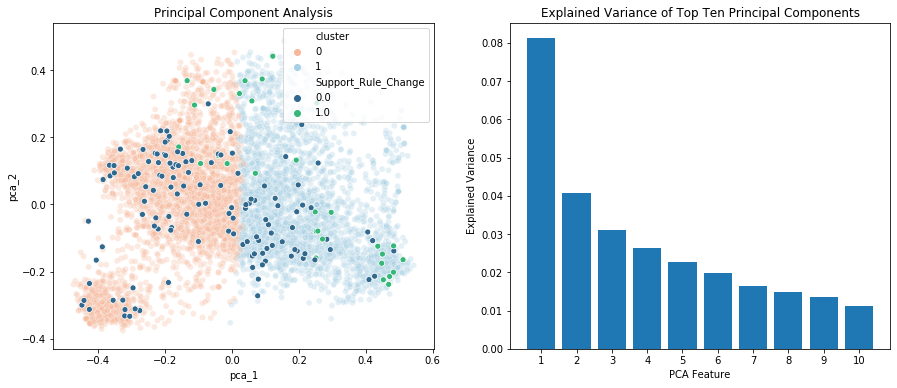

In [292]:
# Plot first two principal components and explained variance
plt.subplots(1, 2, figsize=(15, 6));
plt.subplot(1, 2, 1);
sns.scatterplot(x='pca_1', y='pca_2', data=pca_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='pca_1', y='pca_2', data=samples, hue='Support_Rule_Change', palette='viridis')
plt.title('Principal Component Analysis');

feats = range(1, 11)
plt.subplot(1, 2, 2);
plt.bar(feats, pca.explained_variance_ratio_[:10]);
plt.xticks(feats);
plt.xlabel('PCA Feature');
plt.ylabel('Explained Variance');
plt.title('Explained Variance of Top Ten Principal Components');

plt.savefig('./Figures/PCA_{}{}Lemma.png'.format(chart_title, 'Bigrams' if use_bigrams else ''));

In [293]:
# TSNE cluster visualization
tsne = TSNE(n_components=2, perplexity=30)
tsne_res = tsne.fit_transform(X_data)

In [294]:
tsne_res.shape

(6549, 2)

In [295]:
# Re-create DF with TSNE results
tsne_df = pd.DataFrame(tsne_res, columns=['tsne_1', 'tsne_2'], index=X_train.index)
tsne_df['cluster'] = kmeans.labels_

tsne_df.head()

,tsne_1,tsne_2,cluster
3783,-12.816201,-16.775599,1
2110,7.209436,-51.727764,1
2002,20.631145,1.961196,0
3047,-7.038514,42.972164,0
418,-33.954998,-0.291752,0


In [296]:
# Create TSNE sample DF
tsne_samples = pd.merge(labels, tsne_df[['tsne_1', 'tsne_2']],
                        left_index=True,
                        right_index=True)

tsne_samples.tail(10)

,Support_Rule_Change,tsne_1,tsne_2
193,0.0,-18.040512,5.960535
194,0.0,5.929118,16.831976
195,1.0,-25.790293,-18.988789
196,0.0,48.271961,36.016785
197,1.0,-11.209613,-36.628948
200,0.0,-23.168873,28.660831
201,0.0,39.223701,-9.277461
202,0.0,-40.923168,16.826391
203,0.0,-35.994682,15.250299
204,0.0,-20.863583,4.572628


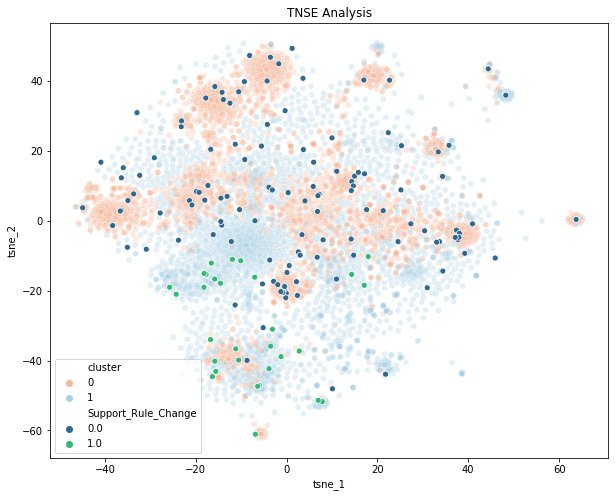

In [297]:
# Plot the TSNE results
plt.figure(figsize=(10, 8));
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_df, hue='cluster', alpha=0.3, palette='RdBu');
sns.scatterplot(x='tsne_1', y='tsne_2', data=tsne_samples, hue='Support_Rule_Change', palette='viridis');
plt.title('TNSE Analysis');
plt.savefig('./Figures/TSNE_{}{}Lemma.png'.format(chart_title, 'Bigrams' if use_bigrams else ''))